the Model used is StyleGAN2 Metfaces
Copyright © 2021, NVIDIA Corporation. All rights reserved.
@inproceedings{Karras2020ada,
  title     = {Training Generative Adversarial Networks with Limited Data},
  author    = {Tero Karras and Miika Aittala and Janne Hellsten and Samuli Laine and Jaakko Lehtinen and Timo Aila},
  booktitle = {Proc. NeurIPS},
  year      = {2020}
}
https://github.com/NVlabs/stylegan2-ada-pytorch?tab=readme-ov-file

## Setting up StyleGAN2 

In [78]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

import torch
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)

!pip install -q tqdm pandas pillow==9.5.0 

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/kaggle/working/stylegan2-ada-pytorch/stylegan2-ada-pytorch
CUDA verfügbar: True
CUDA-Version: 12.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [79]:
!wget -O metfaces.pkl "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"

--2025-11-21 10:03:58--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 3.169.137.62, 3.169.137.110, 3.169.137.120, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|3.169.137.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624133 (364M) [binary/octet-stream]
Saving to: ‘metfaces.pkl’

metfaces.pkl        100%[===================>] 363.94M  15.5MB/s    in 25s     

2025-11-21 10:04:24 (14.5 MB/s) - ‘metfaces.pkl’ saved [381624133/381624133]



In [80]:
!pip install -q --upgrade "pillow>=10.1"
import pickle
import torch
from torchvision.utils import save_image

with open('metfaces.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()   # Generator im eval‑Modus

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
gradio 5.38.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.4 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [81]:
#from IPython.display import Image, display
#z_loaded = torch.load('/kaggle/input/z-bn-test/z_bn_final.pt') 

# (B, 512) – bereits auf CPU

#z_one = z_loaded[0:1].cuda()                # (1, 512) → auf GPU

#z_batch = z_loaded.cuda()                    # (B, 512)
#with torch.no_grad():
    # `noise_mode='random'` ist Standard – du kannst auch 'const' oder 'none' wählen
#    generated = G(z_one, None, truncation_psi=0.7, noise_mode='none')[0]  # (B, C, H, W)

# Normalisieren für Anzeige / Speicherung
    
#generated_norm = (generated * 0.5 + 0.5).clamp(0, 1)

# Als Raster‑Bild speichern (z. B. 4 Bilder pro Zeile)

#save_image(generated_norm, 'metfaces_from_zbn.png', nrow=4)
#display(Image('metfaces_from_zbn.png'))

In [82]:
from pathlib import Path

z_path = Path('/kaggle/input/z-bn-test/z_bn_final.pt')
z_all = torch.load(z_path)            
print('Geladene Form:', z_all.shape)

# Optional: zugehörige Labels (z. B. aus einer CSV‑Datei oder einem .pt‑File)
# Beispiel: labels.npy →  numpy‑Array mit 400 Integer‑Labels
import numpy as np
labels_path = Path('labels.npy')
if labels_path.exists():
    y_labels = np.load(labels_path)    # shape (400,)
    print('Labels geladen, unique classes:', np.unique(y_labels))
else:
    # Falls du keine Labels hast, erstelle Dummy‑Labels (z. B. 0…)
    y_labels = np.zeros(z_all.shape[0], dtype=int)

Geladene Form: torch.Size([400, 512])


In [83]:
def generate_image(z_vec, truncation=0.7, noise_mode='none'):

    with torch.no_grad():
        img = G(z_vec, None, truncation_psi=truncation, noise_mode=noise_mode)[0]  # (1, C, H, W)
    # Normalisieren zu [0, 1] für Anzeige/Speicherung
    img = (img * 0.5 + 0.5).clamp(0, 1)
    return img.squeeze(0) 

In [84]:
def show_image_by_index(idx):
    """Zeigt das Bild, das zu z_all[idx] gehört."""
    z = z_all[idx].unsqueeze(0).cuda()      # (1, 512) → GPU
    img = generate_image(z)              # (C, H, W)
    # Matplotlib‑Anzeige (funktioniert in jedem Notebook)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4,4))
    plt.imshow(img.permute(1,2,0).cpu().numpy())
    plt.title(f'Index {idx} – Label {y_labels[idx]}')
    plt.axis('off')
    plt.show()

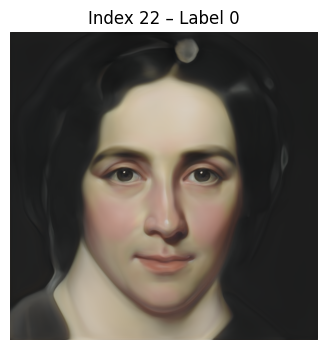

In [88]:
show_image_by_index(22)

In [86]:
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

#img = mpimg.imread('metfaces_samples.png')   # Bild als NumPy‑Array laden
#plt.figure(figsize=(8,8))            # Größe nach Belieben anpassen
#plt.imshow(img)
#plt.axis('off')                     # Achsen ausblenden
#plt.show()

In [87]:
#z = torch.randn(1, G.z_dim).cuda() 

#z:Tensor der Form (N, latent_dim) – N = Anzahl der Bilder, die du gleichzeitig erzeugen willst
#latent_dim = die Dimension des latenten Raums (bei den offiziellen MetFaces‑Modellen ist das 512).

#with torch.no_grad():
    #img = G(z, None, truncation_psi=0.7, noise_mode='const')[0]
    
#G_ema(z, label=None, truncation_psi=1.0, noise_mode='random')
#label : Für bedingte Modelle (z. B. Klassenlabels). MetFaces ist unbedingt, also None.
#truncation_psi : Steuerung der „Trunkierung“ (0.5 ≈ konservativer, 1.0 ≈ volle Vielfalt).
#noise_mode : Wie das pixel‑weise Rauschen im Netzwerk behandelt wird.
#'random' → Standard‑Verhalten (jedes Bild bekommt eigenes Rauschen).
#'const' → Dasselbe Rauschen für alle Layer (nützlich, wenn du nur das latente z variieren willst).
#'none' → Kein zusätzliches Rauschen (nur z wirkt).

#save_image((img * 0.5 + 0.5).clamp(0,1), 'metfaces_samples.png', nrow=4)